<a href="https://colab.research.google.com/github/21kNabeelUddin/Brain-Tumor-MultiClassification-Model/blob/main/Brain_tumor_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!rm -rf ~/.kaggle/kaggle.json



In [16]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syednabeeluddin","key":"1b95e6d90a9d95782713d3c70c778e4f"}'}

In [17]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [18]:
!chmod 600 ~/.kaggle/kaggle.json



In [20]:
!ls -l ~/.kaggle



total 4
-rw------- 1 root root 71 Jan  2 16:39 kaggle.json


In [21]:
!cat ~/.kaggle/kaggle.json


{"username":"syednabeeluddin","key":"1b95e6d90a9d95782713d3c70c778e4f"}

In [22]:
!kaggle datasets list

ref                                                         title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
bhadramohit/customer-shopping-latest-trends-dataset         Customer Shopping (Latest Trends) Dataset         76KB  2024-11-23 15:26:12          19737        389  1.0              
govindaramsriram/crop-yield-of-a-farm                       Crop Yield of a Farm                              28KB  2024-12-28 18:12:16            766         24  1.0              
govindaramsriram/sleep-time-prediction                      Sleep Time Prediction                             28KB  2024-12-28 17:08:56           1131         30  1.0              
hopesb/student-depression-dataset                           Student Depression Dataset.        

In [24]:
!kaggle datasets download -d tombackert/brain-tumor-mri-data

Dataset URL: https://www.kaggle.com/datasets/tombackert/brain-tumor-mri-data
License(s): MIT
 93% 141M/151M [00:01<00:00, 123MB/s] 
100% 151M/151M [00:01<00:00, 94.8MB/s]


In [34]:
import zipfile

# Extract the zip file
with zipfile.ZipFile("brain-tumor-mri-data.zip", 'r') as zip_ref:
    zip_ref.extractall("brain_tumor_data")


In [35]:
!ls brain_tumor_data


brain-tumor-mri-dataset


In [42]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob


#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


#---------------------------------------
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#---------------------------------------


import warnings
warnings.filterwarnings("ignore")


# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [38]:
import os
import pandas as pd

# Path to the extracted dataset folder
base_path = "brain_tumor_data/brain-tumor-mri-dataset"

# Initialize an empty list to store the data
data = []

# Loop through each folder and get image paths and labels
for label in os.listdir(base_path):
    folder_path = os.path.join(base_path, label)  # Get the path for each subfolder

    if os.path.isdir(folder_path):  # Ensure it's a folder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)  # Full path of the image

            # Append the file path and label to the data list
            data.append({"Class Path": file_path, "Class": label})

# Convert the data list to a Pandas DataFrame
df = pd.DataFrame(data)




In [39]:
df

,Class Path,Class
0,brain_tumor_data/brain-tumor-mri-dataset/menin...,meningioma
1,brain_tumor_data/brain-tumor-mri-dataset/menin...,meningioma
2,brain_tumor_data/brain-tumor-mri-dataset/menin...,meningioma
3,brain_tumor_data/brain-tumor-mri-dataset/menin...,meningioma
4,brain_tumor_data/brain-tumor-mri-dataset/menin...,meningioma
...,...,...
7148,brain_tumor_data/brain-tumor-mri-dataset/pitui...,pituitary
7149,brain_tumor_data/brain-tumor-mri-dataset/pitui...,pituitary
7150,brain_tumor_data/brain-tumor-mri-dataset/pitui...,pituitary
7151,brain_tumor_data/brain-tumor-mri-dataset/pitui...,pituitary


# Extrapolary Data Analysis

In [43]:
def count_images(df):
    plt.figure(figsize=(15,7))
    ax = sns.barplot(x=df['Class'].value_counts().index,
                     y=df['Class'].value_counts().values,
                     palette='rocket')
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Number of images in each class')
    plt.show()

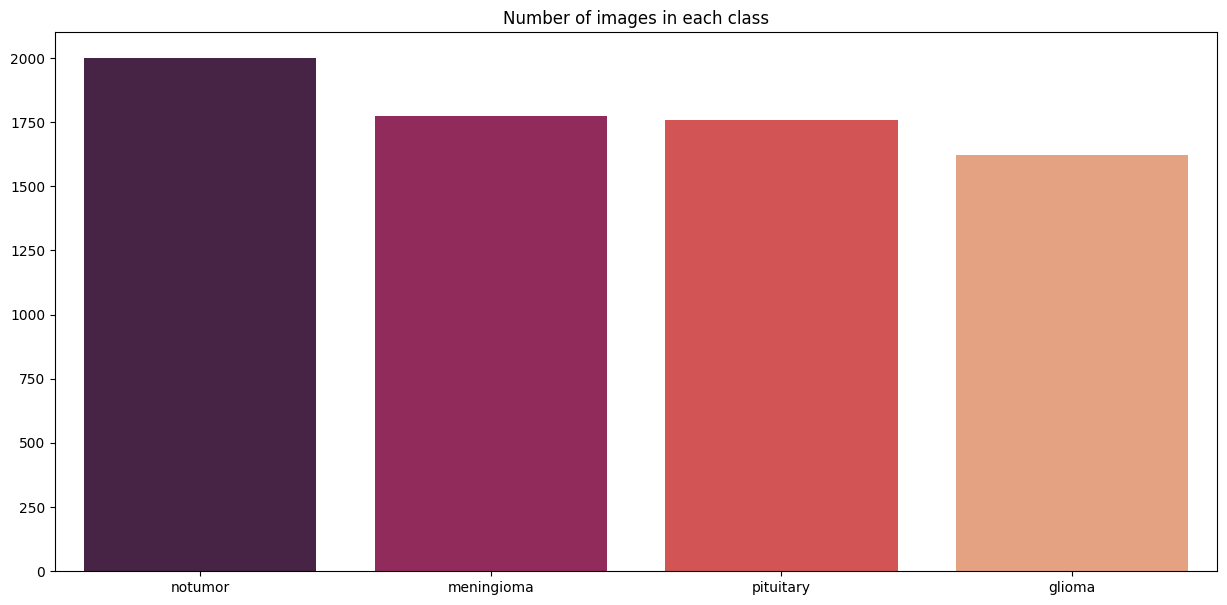

In [44]:
count_images(df)

In [45]:
# Check dimensions of a sample image
from PIL import Image
image_path = df['Class Path'][0]
image = Image.open(image_path)
print(image.size)  # Output: (width, height)


(512, 512)


In [46]:
# Train: 82%, Validation: 8%, Test: 10%

train_df, test_val_df = train_test_split(df, train_size=5722 / 7153, random_state=42, stratify=df['Class'])

valid_df, test_df = train_test_split(test_val_df, train_size=655 / len(test_val_df), random_state=20, stratify=test_val_df['Class'])

print(f"Train size: {len(train_df)} rows")
print(f"Validation size: {len(valid_df)} rows")
print(f"Test size: {len(test_df)} rows")

Train size: 5722 rows
Validation size: 655 rows
Test size: 776 rows


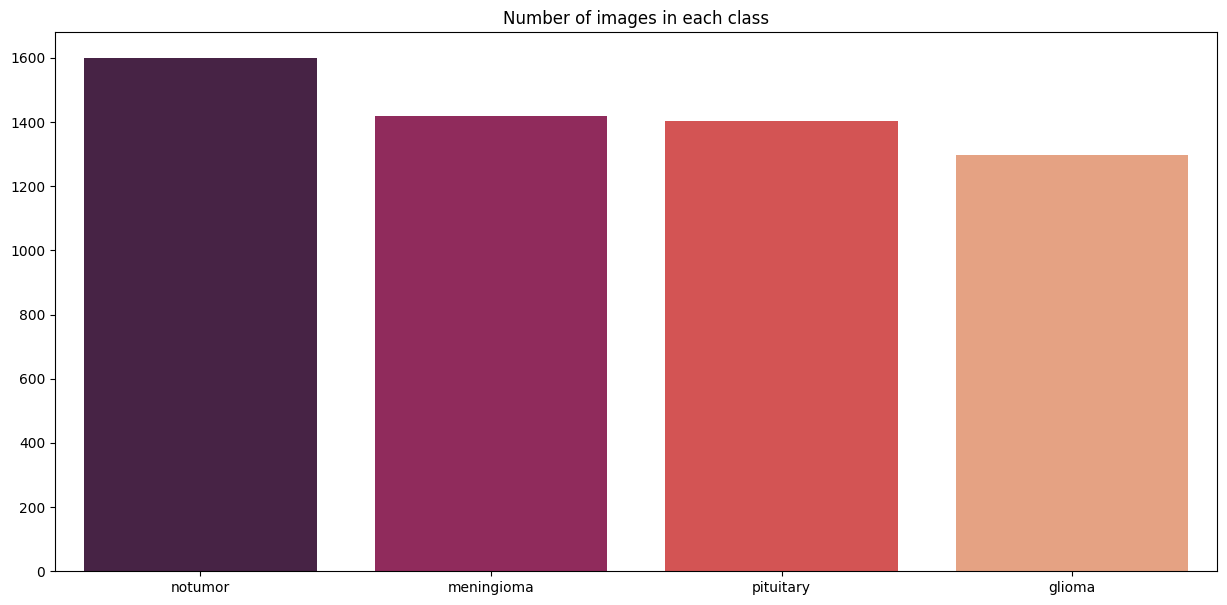

In [47]:
count_images(train_df)

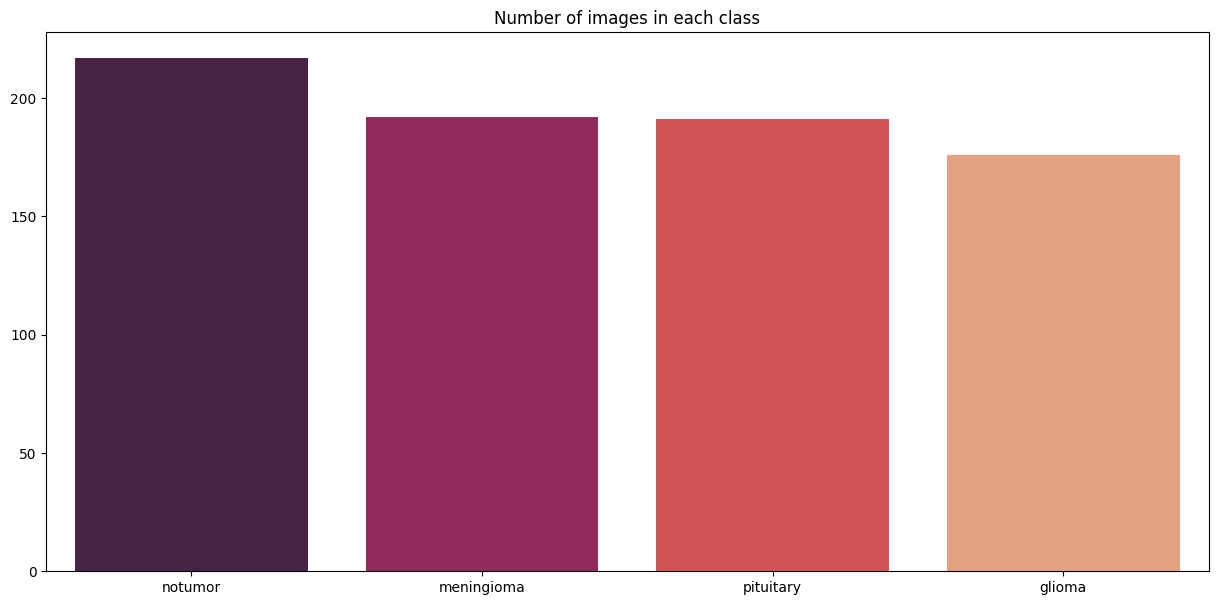

In [48]:
count_images(test_df)

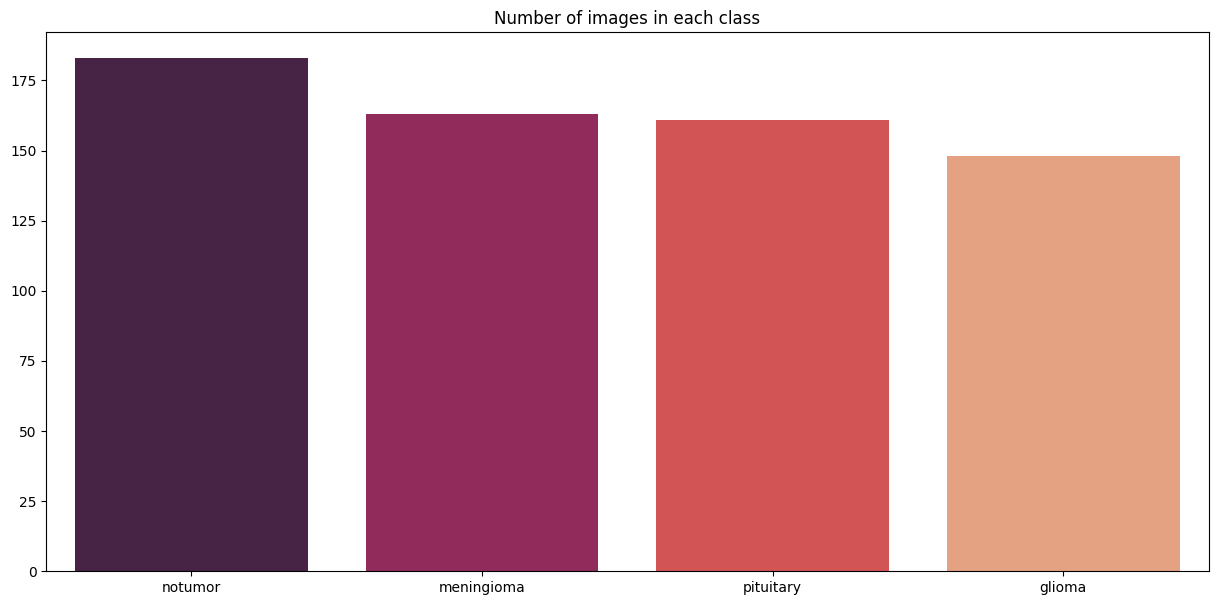

In [49]:
count_images(valid_df)

#PreProcessing

### Data Augmentation

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)




## Resize Images
resizing images from 512x512 to 299x299 inorder to:

1.Reduce memory usage

2.Speed up training.

3.Still preserve enough detail for classification tasks.


In [51]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

test_gen = ImageDataGenerator(rescale=1/255)


train_gen = _gen.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

test_gen = test_gen.flow_from_dataframe(test_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5722 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 776 validated image filenames belonging to 4 classes.


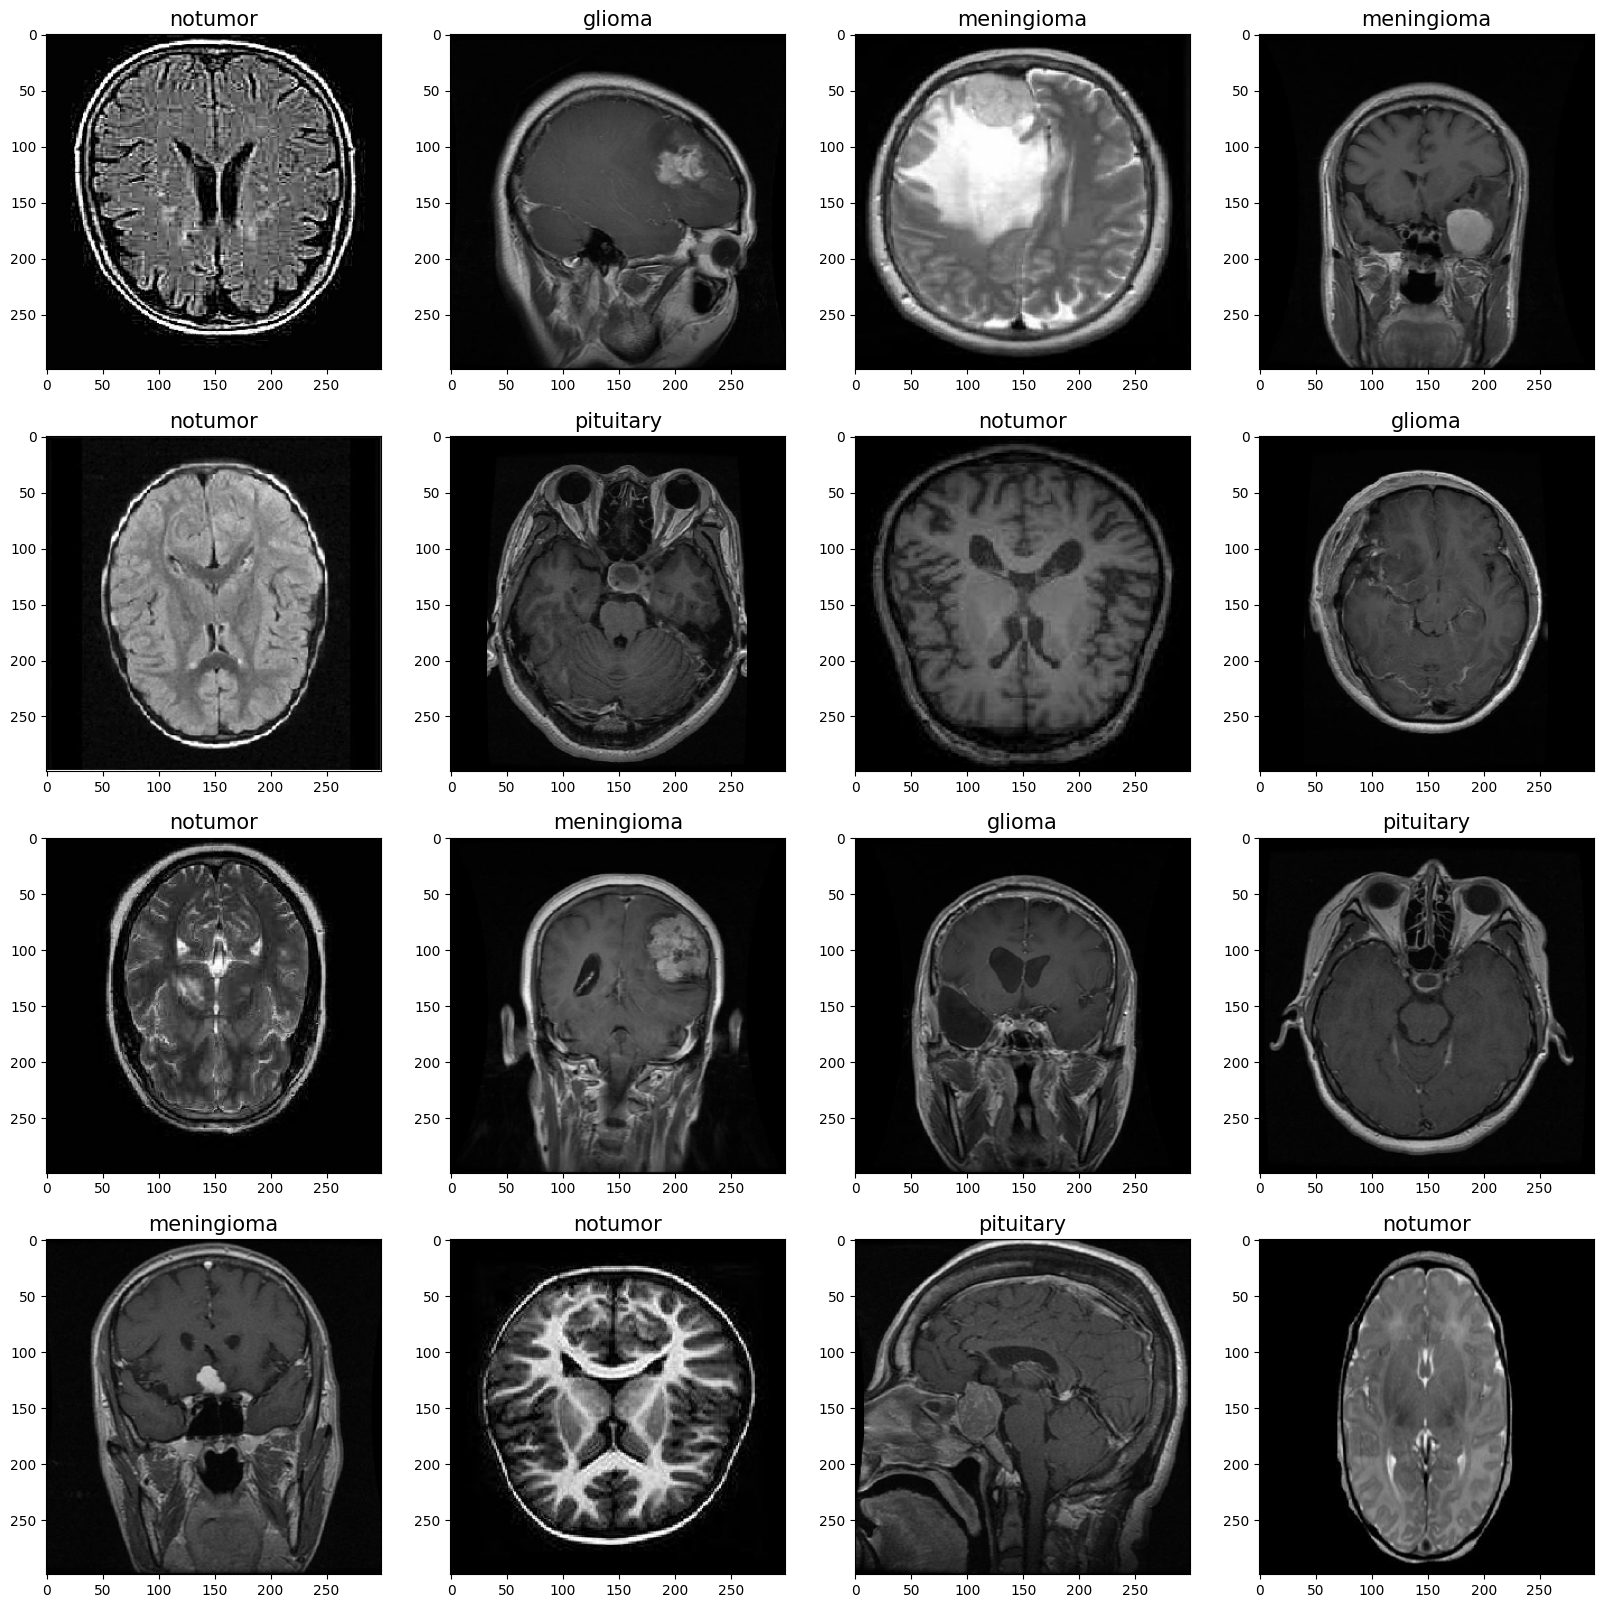

In [52]:
class_dict = train_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(test_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

**Model Building**

In [53]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, concatenate, BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define the base model with combined pooling
base_model = tf.keras.applications.Xception(include_top=False,
                                            weights="imagenet",
                                            input_shape=(299, 299, 3))

avg_pool = GlobalAveragePooling2D()(base_model.output)
max_pool = GlobalMaxPooling2D()(base_model.output)
combined_pool = concatenate([avg_pool, max_pool])  # Combine average and max pooling

# Add custom layers on top of the base model
x = Flatten()(combined_pool)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Add L2 regularization
x = BatchNormalization()(x)  # Add Batch Normalization
x = Dropout(rate=0.25)(x)
outputs = Dense(4, activation='softmax')(x)  # Final classification layer

# Define the complete model
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True





83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Setting up Callbacks**

In [54]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

opt = Adam(learning_rate=lr_schedule)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', verbose=1)

**# Training The model**

In [55]:
# Train the model
history = model.fit(train_gen,
                    validation_data=valid_gen,
                    epochs=10,
                    callbacks=[early_stopping, model_checkpoint])

# Load the best model weights
model.load_weights('best_model.keras')

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.8302 - loss: 2.1233 - precision: 0.8437 - recall: 0.8083
Epoch 1: val_loss improved from inf to 0.56499, saving model to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 141s 565ms/step - accuracy: 0.8306 - loss: 2.1189 - precision: 0.8441 - recall: 0.8088 - val_accuracy: 0.9511 - val_loss: 0.5650 - val_precision: 0.9526 - val_recall: 0.9511
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9713 - loss: 0.3884 - precision: 0.9733 - recall: 0.9691
Epoch 2: val_loss improved from 0.56499 to 0.22190, saving model to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 66s 360ms/step - accuracy: 0.9713 - loss: 0.3881 - precision: 0.9733 - recall: 0.9691 - val_accuracy: 0.9664 - val_loss: 0.2219 - val_precision: 0.9723 - val_recall: 0.9649
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9894 - loss: 0.1330 - precision: 0.9904 - recall: 0.9878
Epoch 3: val_loss improved from 0.22190 to 0.13716, sa

# model Testing

In [56]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_gen, verbose=1)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 252ms/step - accuracy: 0.9823 - loss: 0.1411 - precision: 0.9841 - recall: 0.9823
Test Loss: 0.1295814961194992
Test Accuracy: 0.9819587469100952
Test Precision: 0.9832258224487305
Test Recall: 0.9819587469100952


In [57]:
import numpy as np

# Make predictions on the test set
predictions = model.predict(test_gen, verbose=1)

# Get the predicted class labels (the index with the highest probability)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels
true_classes = test_gen.classes

# Get the class labels (names of the tumor types)
class_labels = list(test_gen.class_indices.keys())


49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step


**Evaluation**

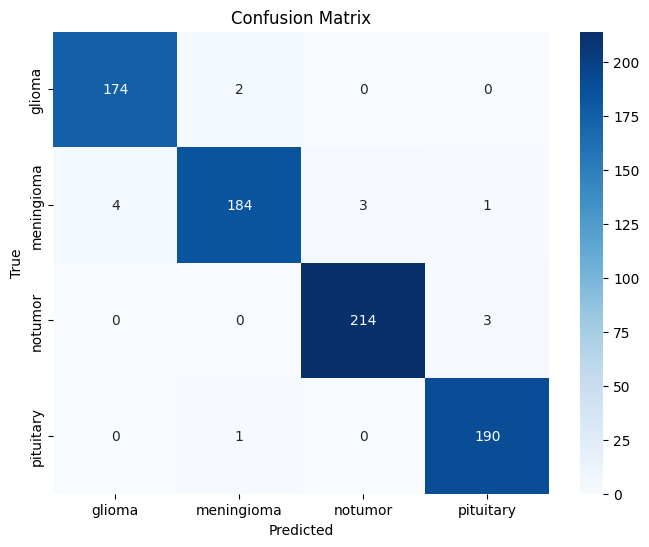

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [59]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the classification report
print(report)


              precision    recall  f1-score   support

      glioma       0.98      0.99      0.98       176
  meningioma       0.98      0.96      0.97       192
     notumor       0.99      0.99      0.99       217
   pituitary       0.98      0.99      0.99       191

    accuracy                           0.98       776
   macro avg       0.98      0.98      0.98       776
weighted avg       0.98      0.98      0.98       776



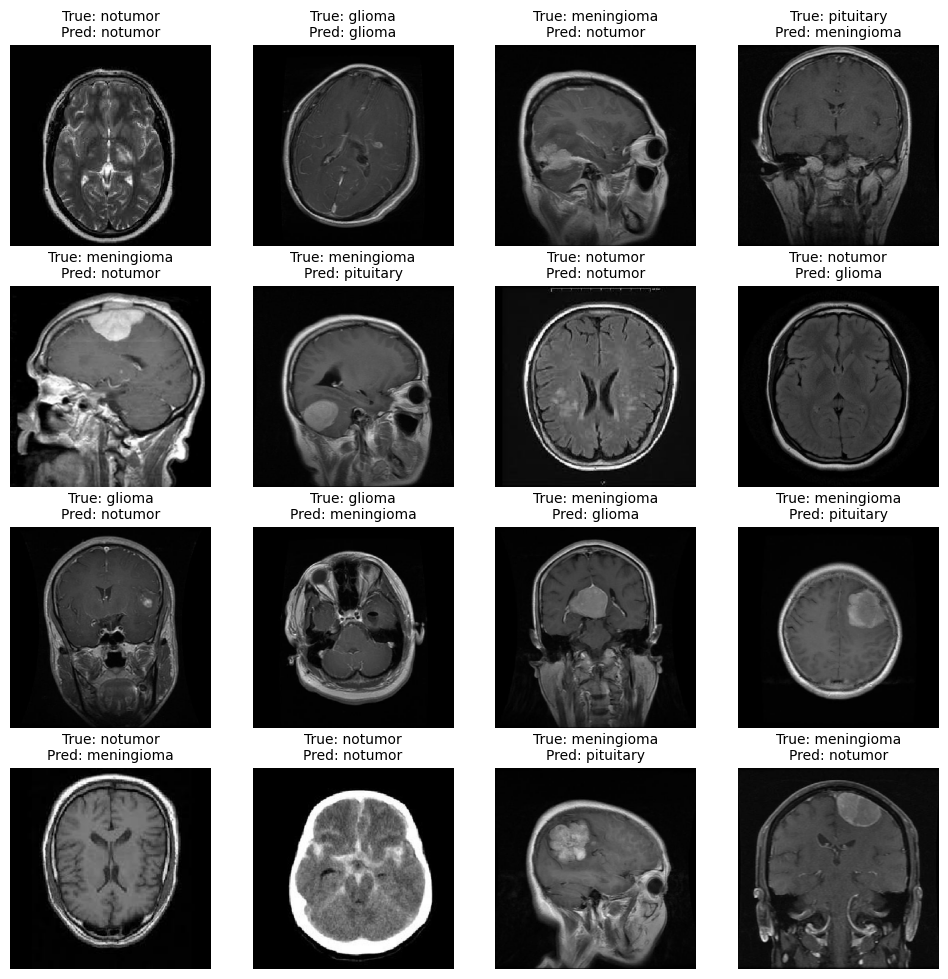

In [61]:
# Get a batch of images and labels from the test generator
images, labels = next(test_gen)  # This will give you the next batch from the iterator

# Visualize a few test images with their predictions
plt.figure(figsize=(12, 12))

for i in range(16):  # Display 16 images
    plt.subplot(4, 4, i + 1)
    image = images[i]  # Get the i-th image from the batch
    true_label = class_labels[np.argmax(labels[i])]  # Get the true label
    predicted_label = class_labels[predicted_classes[i]]  # Get the predicted label

    plt.imshow(image)
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
    plt.axis('off')

plt.show()


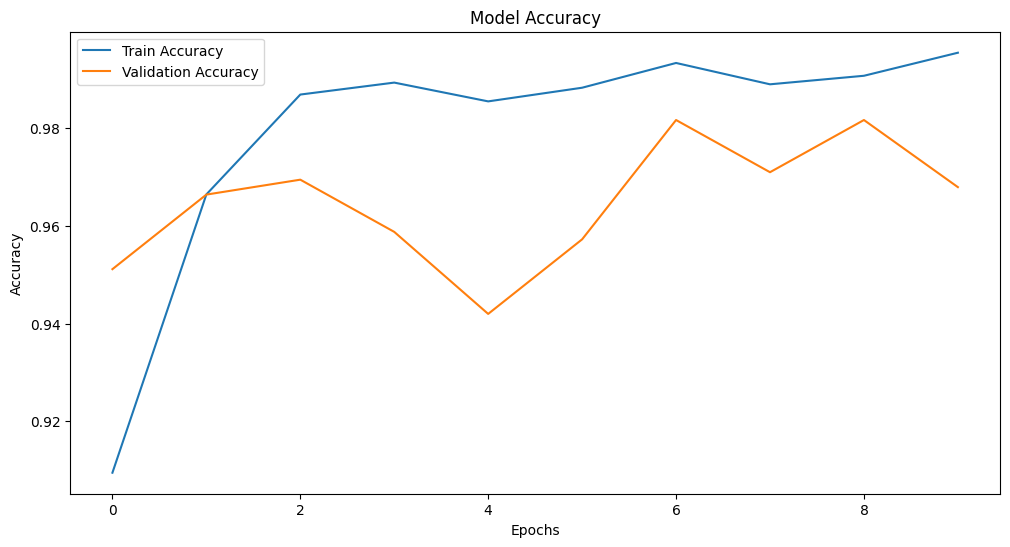

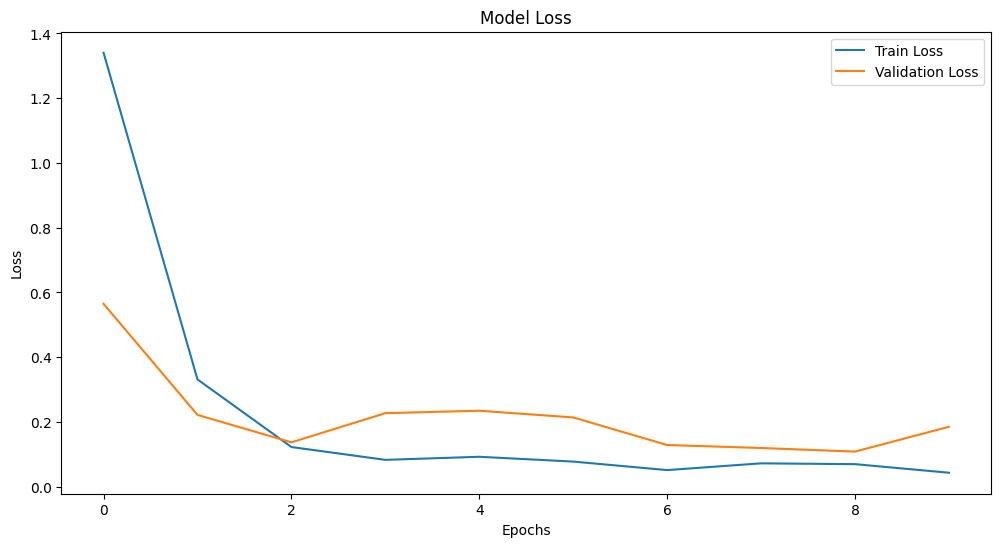

In [62]:
# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [64]:
# Saving the final model
model.save('brain_tumor_xception_best_epoch9.keras')
